In [1]:
!pip install autograd

     |████████████████████████████████| 829 kB 8.9 MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=1556d6f0abdc38d7807fa3bec097542e7ff204f59b0509120d15f541ddafe229
  Stored in directory: /home/davidvdm/.cache/pip/wheels/b6/86/a9/2c2d40e3c7d837ca251d7cb66f06a283c8679fa17421e8ddeb
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=1a69c3fa7470a3335e039eee86ae6469f97826d98ff1ee2fd505317b48c86308
  Stored in directory: /home/davidvdm/.cache/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built autograd future


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from autograd import grad

from os.path import join
from typing import Union, Iterable, List, Optional

import sys
sys.path.append('/project/svd-kernels')

from src.callbacks.utils import orthogonality_number

In [3]:
np.random.seed(42)  # Set seed
plt.style.use('dark_background')  # Dark mode

## Cayley transform calculation

#### Benchmark calculation speed for Cayley transform
Cayley transform is calculated as follows.

\begin{align}
\phi_{\nu}(X) = (I + \nu X)^{-1} \cdot (I - \nu X) \hspace{12pt} | \hspace{6pt} X^T = -X
\end{align}

The corresponding descent curve on the Stieffel manifold.

\begin{align}
    X^n(\nu) = \phi_{\nu}(W^n) \cdot X^{n-1} \hspace{12pt} | \hspace{6pt} W^n = \nabla X X^T - X \nabla X^T
\end{align}

The time complexity of this is $\mathcal{O}(2 \cdot N^3) \rightarrow X\in \mathbb{R}^{N x R}$. <br>
$\mathcal{O}(N^3)$ from the matrix inversion and $\mathcal{O}(N^3)$ from the matrix multiplication

Calculate with fixed point iteration. <br>
\begin{gather}
(I + \nu X) \cdot \phi_{\nu}(X) = (I - \nu X) \\
\phi_{\nu}(X)  = (I - \nu X) - \nu X \cdot \phi_{\nu}(X) \\
\phi_{\nu}(X)  = I - \nu X \cdot (I + \phi_{\nu}(X))
\end{gather}

Calculate iteratively 
1. $\phi^0_{\nu} \leftarrow I - \nu X$ <br>
2. $\phi_{\nu}^k \leftarrow I - \nu X \cdot (I + \phi_{\nu}^{k-1})$

The time complexity of this is $\mathcal{O}(k \cdot N^3) \rightarrow X\in \mathbb{R}^{N x R}$. <br>
$k$ times $\mathcal{O}(N^3)$ from the matrix multiplication in each iteration

In [4]:
def phi(var: tf.Tensor, grad: tf.Tensor, nu: Union[float, tf.Tensor], k: Optional[int] = None) -> tf.Tensor:
    """Calculate Cayley transform descent curve given a variable an it's gradient.
    Parameters
    ----------
    var: tf.Tensor
        Variable values tensor
    grad: tf.Tensor
        Variable gradients tensor
    nu: tf.Tensor or float
        Learning rate on manifold
    k: Optional[int]
        Number of iterations for fixed-point iteration calculation
        (default is None)
    Returns
    -------
        Cayley transformed gradient curve
    """
    # Calculate asymmetric gradient
    w = grad @ tf.transpose(var) - var @ tf.transpose(grad)
    # Scale with learning rate
    w *= tf.divide(nu, 2.)
    # Get unit matrix
    i = tf.eye(w.shape[0])
    # Calculate Cayley with inverse when no iterations are defined
    if k is None:
        y = tf.linalg.inv(i + w) @ (i - w)
    else:
        assert k > -1
        # Initialize y
        y = i - w  
        # Calculate iteratively
        for _ in range(k):    
            y = i - w@(i + y)
    return y

Woodbury-Morrison formula
\begin{gather}
\phi_{\nu}(X) = I + \chi_{\nu}(X) \\
\chi_{\nu}(X) = -\nu A \cdot (I + \frac{\nu}{2}B^TA)^{-1}B^T \\
A = [\nabla X, X] \\
B = [X, -\nabla X]
\end{gather}

Fixed point iteration <br>
\begin{align}
(I + \nu X) \cdot (I + \chi_{\nu}(X)) = (I - \nu X) \\
I + \chi_{\nu}(X) = (I - \nu X) - \nu X \cdot (I + \chi_{\nu}(X)) \\
\chi_{\nu}(X)  = - \nu X \cdot (2I + \chi_{\nu}(X))
\end{align}

Calculate iteratively 
1. $\chi^0_{\nu} \leftarrow - \nu X$ <br>
2. $\chi_{\nu}^k \leftarrow - \nu X \cdot (2I + \chi_{\nu}^{k-1})$

In [5]:
def chi(var: tf.Tensor, grad: tf.Tensor, nu: float, k: Optional[int] = None) -> tf.Tensor:
    """Calculate additive part of  phi = I + chi given a variable and it's gradient.
    Notes
    -----
    Nu can't be tf.Tensor due to shape in calculation of skew part.
    This is why adaptive learning rate are pressed into gradient calculation.
    See SVDAdam for more info.

    Parameters
    ----------
    var: tf.Tensor
        Variable values tensor
    grad: tf.Tensor
        Variable gradients tensor
    nu: float
        Learning rate on manifold
    k: Optional[int]
        Number of iterations for fixed-point iteration calculation
        (default is None)
    Returns
    -------
        Woodbury Morrison formulae for chi
    """
    if k is None:
        # Get 2R x N parts for calculation
        a = tf.concat([grad, var], axis=1)
        b = tf.concat([var, -grad], axis=1)
        # Calculate skew matrix
        skew = tf.transpose(b) @ a
        skew *= tf.divide(nu, 2.)
        skew += tf.eye(skew.shape[0])
        # Calculate inverse
        skew_inv = tf.linalg.inv(skew, adjoint=False)
        # Calculate chi
        y = - nu * a @ skew_inv @ tf.transpose(b)
    else:
        assert k > -1
        # Calculate asymmetric gradient
        w = grad @ tf.transpose(var) - var @ tf.transpose(grad)
        # Scale with learning rate
        w *= tf.divide(nu, 2.)
        # Get unit matrix
        i = tf.eye(w.shape[0])
        # Initialize chi
        y = - w
        # Calculate iteratively
        for _ in range(k):
            y = - w @ (2*i + y)
    return y

### Test computational speed of $\phi$ and $\chi$ calculations <br>
* Generate random matrix $A$.
\begin{gather}
    A \in \mathbb{R}^{N x N}
\end{gather}
* Generate orhogonal $X$ using $\phi$.
\begin{gather}
    X^* = \phi(A, I, 1) \in \mathbb{R}^{N x N} \\
    X = [X^*_0, ..., X^*_R] \in \mathbb{R}^{N x R} | \hspace{6pt} X^TX = I
\end{gather}
* Generate set of random gradients
\begin{gather}
    G \rightarrow \{\nabla X^i, \hspace{1pt} \forall i \in [0 \dots K]\}
\end{gather}

In [53]:
# Set matrix dimensions
units = 2048
rank = 128

# Optimization parameters
nu = 10e-2
fixed_point_iterations = 25

# Number of steps
steps = 500

# Initialize matrices
A = tf.random.normal((units, units))
I = tf.eye(units)
X = phi(A, I, nu)[..., :rank]
G = [tf.random.uniform((units, rank)) for i in range(steps)]

In [54]:
# List of fixed point iterations to test
iterations_list = [2, 4, 8, 16, 32]
# List to contain times
times_list = []
curves_list = []
# Run for different number of fixed point iterations
for fixed_point_iterations in iterations_list:
    # Initialize descent curve with X for each method
    curves = {'phi-inverse': [X], 'phi-fixed': [X], 'chi-inverse': [X], 'chi-fixed': [X]}
    # Initialize calculation time list for each method
    times = {'phi-inverse': [], 'phi-fixed': [], 'chi-inverse': [], 'chi-fixed': []}

    # Calculate step for each 'gradient'
    for g in G:
        # Calculate step with each method
        for key in curves.keys():
            # Latest point on curve as starting point
            x = curves[key][-1]
            # Select inverse or fixed point
            if 'inverse' in key:
                k = None
            else:
                k = fixed_point_iterations
            # Select method
            if 'phi' in key:
                start = timer()
                c = phi(x, g, nu, k) - tf.eye(x.shape[0])
                end = timer()
            else:
                start = timer()
                c = chi(x, g, nu, k)
                end = timer()
            # Update on curve
            x += c@x
            # Add to curve
            curves[key].append(x)
            # Add times
            times[key].append(end - start)
    # Add all times to list
    times_list.append(times)
    curves_list.append(curves)

KeyboardInterrupt: 

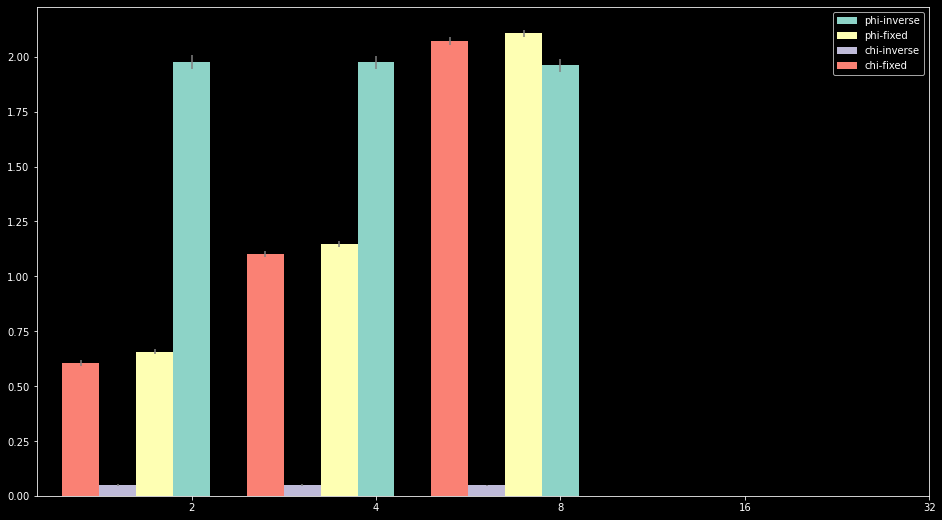

In [55]:
keys = times_list[0].keys()
n_keys = len(list(keys))
width = .8/n_keys

plt.figure(figsize=(16, 9))
for i, key in enumerate(keys):
    plt.bar(
        x=np.arange(len(times_list)) - i * width,
        width=width, 
        height=[np.mean(times[key]) for times in times_list], 
        yerr=[np.std(times[key]) for times in times_list], label=key,
        ecolor='grey'
    )
    plt.xticks(np.arange(len(iterations_list)), iterations_list)
plt.legend()
plt.show()

Since the fixed point iterations requires matrix multiplications the computational expense of the approximated calculation quickly outgrows the exact inverse calculation. <br>
By plotting the differences between the actual inverse and the fixed-point approaximations we can get an idea if there is a point where the computational speed for the fixed point iterations is lower than the full inverse without significant loss in performance.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
for i, curves in enumerate(curves_list):
    axes[0].plot([tf.reduce_mean(np.abs(x - y)) for x, y in zip(curves['phi-inverse'], curves['phi-fixed'])], label=iterations_list[i])
    axes[1].plot([tf.reduce_mean(np.abs(x - y)) for x, y in zip(curves['chi-inverse'], curves['chi-fixed'])], label=iterations_list[i])
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

### Test performance of $\phi$ and $\chi$ calculations <br>
* Generate random matrix $A$ & $B$.
\begin{gather}
    (A, B) \in (\mathbb{R}^{N x N}, \mathbb{R}^{N x N})
\end{gather}
* Generate orhogonal $X$ & $Y$ using $\phi$.
\begin{gather}
    X^* = \phi(A, I, 1) \in \mathbb{R}^{N x N} \\
    X = [X^*_0, ..., X^*_R] \in \mathbb{R}^{N x R} | \hspace{6pt} X^TX = I \\
    Y^* = \phi(B, I, 1) \in \mathbb{R}^{N x N} \\
    Y = [Y^*_0, ..., Y^*_R] \in \mathbb{R}^{N x R} | \hspace{6pt} Y^TY = I
\end{gather}
* Optimize $A \rightarrow B$ using descent curve with loss function $\mathcal{L}$.
\begin{gather}
    \mathcal{L}(X^k, Y) = \sqrt{\frac{1}{NR}\sum_{ij} (X^k_{ij} - Y_{ij})^2}
\end{gather}

In [38]:
# Set matrix dimensions
units = 32
rank = 16

# Optimization parameters
nu = 10e-2
fixed_point_iterations = 4

# Number of steps
steps = 5000

# Initialize matrices
A = tf.random.normal((units, units))
B = tf.random.normal((units, units))
I = tf.eye(units)
X = phi(A, I, nu)[..., :rank]
Y = phi(B, I, nu)[..., :rank]

# Define loss function
def loss_fn(x, y):
    return ((x-y)**2).mean()

grad_fn = grad(loss_fn)

In [39]:
# Initialize descent curve with X for each method
curves = {'phi-inverse': [X], 'phi-fixed': [X], 'chi-inverse': [X], 'chi-fixed': [X]}

# Calculate step for each 'gradient'
for step in range(steps):
    # Calculate step with each method
    for key in curves.keys():
        # Latest point on curve as starting point
        x = curves[key][-1]
        # Calculate gradient with numpy autograd
        g = grad_fn(x.numpy(), Y.numpy())
        # Select inverse or fixed point
        if 'inverse' in key:
            k = None
        else:
            k = fixed_point_iterations
        # Select method
        if 'phi' in key:
            c = phi(x, g, nu, k) - tf.eye(x.shape[0])
        else:
            c = chi(x, g, nu, k)
        # Update on curve
        x += c@x
        # Add to curve
        curves[key].append(x)

#### Method dependence of loss

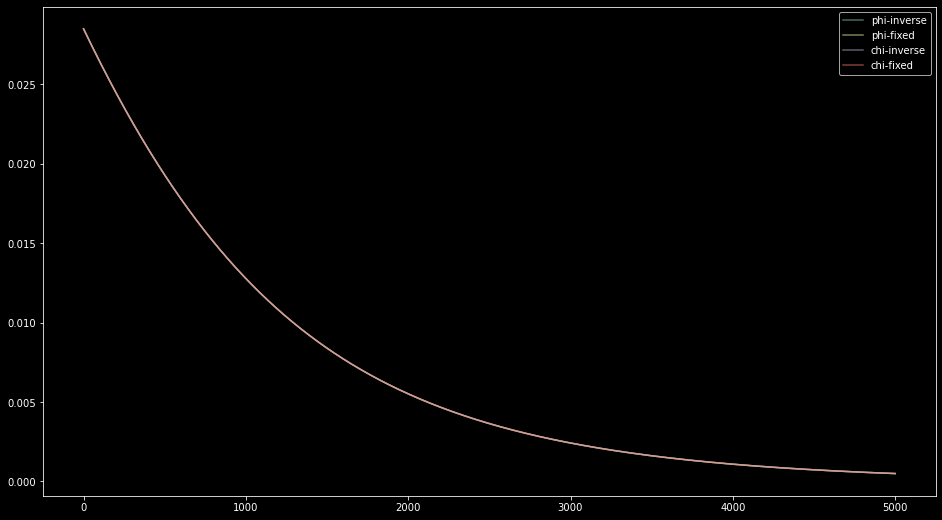

In [40]:
# Plot loss for each different method
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
for i, key in enumerate(curves.keys()):
    plt.plot([loss_fn(x.numpy(), Y.numpy()) for x in curves[key]], label=key, alpha=0.5)
plt.legend()
plt.show()

All methods both fixed point iteration and inverse variants of both $\chi$ and $\phi$ give identital loss function decrease.

#### Method dependence of orthogonality

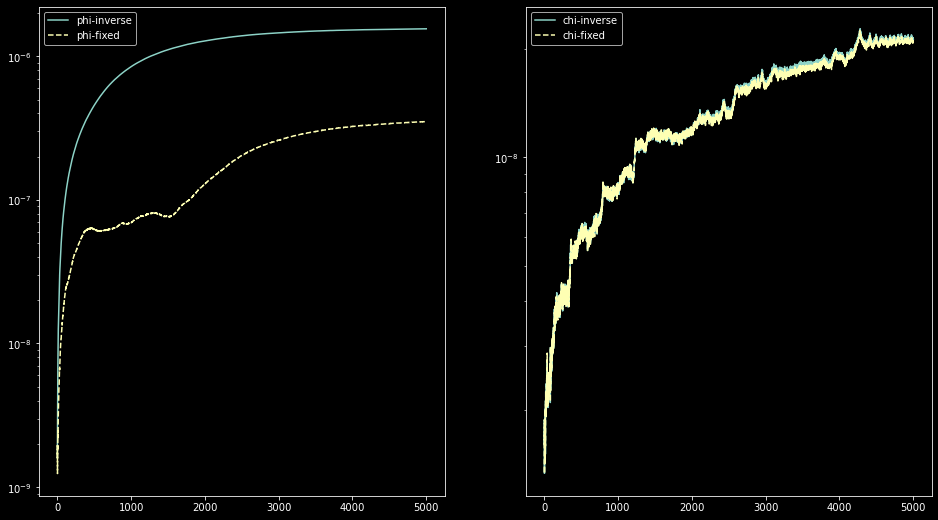

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
for key in curves.keys():
    i = 0 if 'phi' in key else 1
    linestyle = 'dashed' if 'fixed' in key else 'solid'
    axes[i].plot([orthogonality_number(x) for x in curves[key]], label=key, linestyle=linestyle)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

Both methods preserve orthogonality. <br> Some observations can be made though. <br>
* $\phi$ has a steeper orthogonality drop-off than $\chi$.
* The fixed point calculation for $\chi$ has no deviation with it's inverse counterpart while for $\phi$ there is a difference.

It seems that eventhough the loss descent is the same for each method the path over/near the manifold is slightly different. <br>
Plot differences between curves.
* Difference between fixed-point and inverse approach for both $\chi$ and $\phi$.
* Difference between $\chi$ and $\phi$ for both fixed-point and inverse respectively.

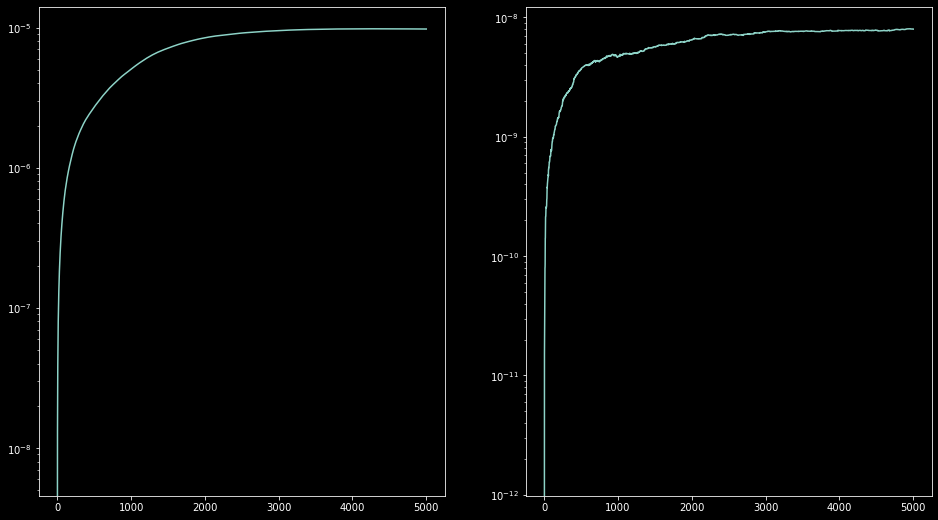

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].plot([tf.reduce_mean(np.abs(x - y)) for x, y in zip(curves['phi-inverse'], curves['phi-fixed'])])
axes[1].plot([tf.reduce_mean(np.abs(x - y)) for x, y in zip(curves['chi-inverse'], curves['chi-fixed'])])
axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.show()

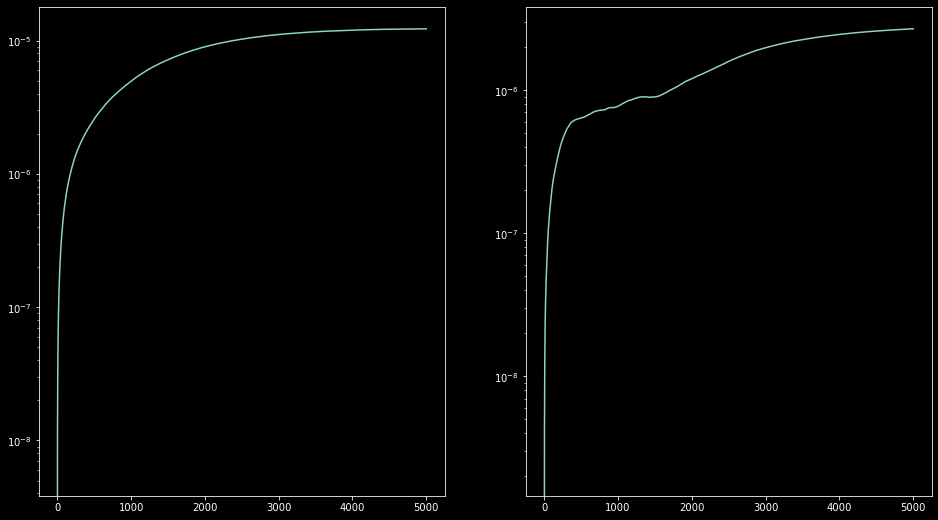

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].plot([tf.reduce_mean(np.abs(x - y)) for x, y in zip(curves['phi-inverse'], curves['chi-inverse'])])
axes[1].plot([tf.reduce_mean(np.abs(x - y)) for x, y in zip(curves['phi-fixed'], curves['chi-fixed'])])
axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.show()

All calculations with $\phi$ consistently deviate more than calculations using $\chi$. <br> 
This would indicate less floating-point error dependence. 